<a href="https://colab.research.google.com/github/MaruanArias/CNN_ClasificadorFrijoles/blob/main/CNN_ClasificadorFrijoles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

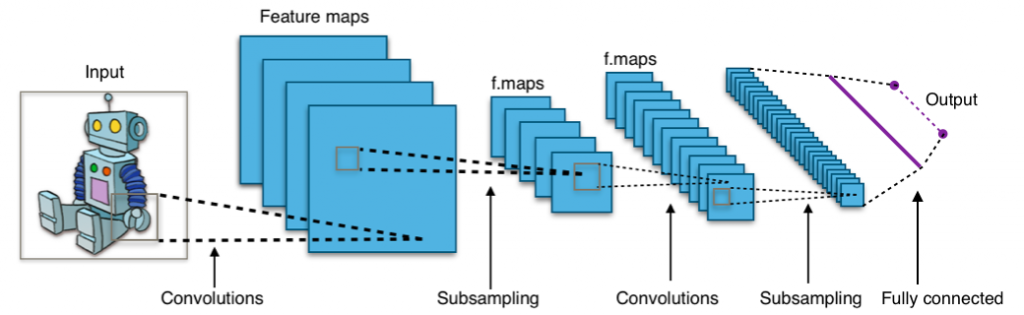

In [ ]:
!killall ngrok

In [ ]:
!pip install twilio flask requests flask-ngrok

In [ ]:

!mkdir -p /drive/ngrok-ssh
%cd /drive/ngrok-ssh
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip -O ngrok-stable-linux-amd64.zip
!unzip -u ngrok-stable-linux-amd64.zip
!cp /drive/ngrok-ssh/ngrok /ngrok
!chmod +x /ngrok

#colocar tu token
!/ngrok authtoken #Tu token

In [ ]:
import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

from skimage import io

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

#Descargamos el data set de la mata del frijol
datos, metadatos = tfds.load('beans', as_supervised=True, with_info=True)

#Obtener en variables separadas los datos de entrenamiento
#datos_entrenamiento, datos_pruebas, datos_validacion = datos['train'], datos['test'], datos['validation']

In [ ]:
metadatos

In [ ]:
#tfds.as_dataframe(datos['train'].take(5),metadatos)
tfds.show_examples(datos['train'], metadatos)

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Trasformación imagenes

In [ ]:
datos_entrenamiento = []
TAMANO_IMG=150

In [ ]:
for i, (imagen, etiqueta) in enumerate(datos['train']): # Todos los datos
  imagen = cv2.resize(imagen.numpy(),(TAMANO_IMG, TAMANO_IMG))
  #imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 3)#Cambiar tamaño 150, 150,
  datos_entrenamiento.append([imagen, etiqueta])
 

In [ ]:
datos_entrenamiento[300]

In [ ]:
len(datos_entrenamiento)

In [ ]:
X = [] #imagenes de entrada (pixeles)
y = [] #etiquetas (Frijol sano [0], Frijoles Enfermos_tipo A [1], Frijoles Enfermos_tipo B [2])
for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

In [ ]:
X

In [ ]:
import numpy as np
X = np.array(X).astype(float)/255

In [ ]:
y

In [ ]:
len(np.unique(y))

In [ ]:
y = np.array(y)

In [ ]:
X.shape

# MODELOS CNN Y DENSO

In [ ]:
from tensorflow.keras.utils import to_categorical

y_one_hot = to_categorical(y)


In [ ]:

modeloCNN_v1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

## Compilacion Modelo

In [ ]:
modeloCNN_v1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
tensorboard_CNN_v1 = TensorBoard(log_dir='logs/cnn_v1')
modeloCNN_v1.fit(X,y, batch_size=32, validation_split=0.40, epochs=100, callbacks=[tensorboard_CNN_v1,early_stop])

In [ ]:
!kill 2314

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Aumento del dataset

In [ ]:
for i in range(10):
  plt.subplot(2,5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X[i])

In [ ]:
#Importar el generador con el aumento de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range =0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7,1.4],
    horizontal_flip=True,
    vertical_flip=True
)  

datagen.fit(X)

plt.figure(figsize=(20,8))

for imagen, etiqueta in datagen.flow(X, y, batch_size=10, shuffle=False):
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(imagen[i])
  break

In [ ]:

modeloCNN_v1_AD = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


In [ ]:

modeloCNN_v1_AD.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
len(X)*.85 #878.9
len(X) - 878.9 # 155

In [ ]:
X_entrenamiento = X[:878]
X_validacion = X[878:]

y_entrenamiento = y[:878]
y_validacion = y[878:]

In [ ]:
data_gen_entrenamiento = datagen.flow(X_entrenamiento,y_entrenamiento, batch_size=32)

In [ ]:
import gc
gc.collect()

In [ ]:
tensorboardCNN_v1_AD = TensorBoard(log_dir='logs/cnn_v1_AD')

modeloCNN_v1_AD.fit(
    data_gen_entrenamiento,
    epochs=100, batch_size = 32,
    validation_data =(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento)/float(32))),
    validation_steps=int(np.ceil(len(X_validacion)/ float(32))),
    callbacks=[tensorboardCNN_v1_AD,early_stop]

)

In [ ]:
modeloCNN_v1_AD.save('beans-sanos-enfermos-cnn-ad.h5')

In [ ]:
modeloCNN_v1_AD.save('/content/beans-sanos-enfermos-cnn-ad.h5')

In [ ]:
!pip install tensorflowjs

In [ ]:
!mkdir carpeta_salida

In [ ]:
!tensorflowjs_converter --input_format keras beans-sanos-enfermos-cnn-ad.h5 carpeta_salida

In [ ]:
!pip install nbconvert

In [ ]:
!jupyter nbconvert --to html ClasificadorFrijoles.ipynb

In [ ]:
# Carga el modelo guardado
modeloCNN_v1_AD = tf.keras.models.load_model('/content/beans-sanos-enfermos-cnn-ad.h5')

In [ ]:
#import tensorflow as tf
from PIL import Image
import numpy as np

In [ ]:
TipoEnfermadad1="Enfermedad: Phaeoisariopsis griseola (Sacc.) Ferraris (Hongo) - MANCHA ANGULAR.\n"
ImportanciaEconomica="Importancia Economica:Puede causar pérdidas entre 40 y 80% en rendimiento en los cultivos. Los síntomas son más frecuentes en hojas y vainas, aunque también aparecen en tallos\n"
CondicionesEnfermedad1="Condiciones adecuadas para la enfermedad: La mancha angular es común en regiones con temperaturas intermedias (18-28 C), y períodos de lluvia alternados con días secos.\nLa enfermedad se transmite por semilla.\n El hongo sobrevive en restos de cosechas anteriores y en el campo se disemina rápidamente por el viento\n "
ManejoEnfermedad1="Manejo integrado:\n Usar semilla sana y nueva. Eliminar del campo restos de cosechas anteriores muy afectadas.\nRotar por un año con cualquier cultivo que no sea algún tipo de frijol.\n En casos de ataques anteriores severos aplicar fungicidas (azoxistrobina, benomil, carbendazim,epoxiconazol maneb, óxido de cobre) antes de la quinta semana de edad del cultivo"

TipoEnfermadad2="Enfermedad: Uromyces appendiculatus. \n"
ImportanciaEconomica2="Importancia Economica:Las pérdidas en rendimiento están alrededor del 25% de los cultivos.\n   "
CondicionesEnfermedad2="Condiciones adecuadas para la enfermedad: La roya es favorecida en ambientes con temperaturas moderadas (17-27 C), y lluvias frecuentes, o noches frescas con períodos prolongados de rocío durante prefl oración y floración\n"
ManejoEnfermedad2="Manejo integrado:\n Rotar cultivos y eliminar restos de cosecha ayudan a reducir el ataque, pero no siempre es suficiente.\nNo sembrar muy tupido.\n Aplicar fungicidas (carboxin, clorotalonil, oxicarboxin, triadimefon) a partir de la tercera semana o antes de floración."

In [ ]:
# Cargar imagen prueba
img = Image.open('/content/frijol4.png')
img = img.resize((150, 150))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Usa el modelo para predecir la clase de la imagen
predicciones = modeloCNN_v1_AD.predict(img_array)
clase = np.argmax(predicciones)

if clase == 0:
  predicionFrijol = TipoEnfermadad1 + ImportanciaEconomica + CondicionesEnfermedad1 + ManejoEnfermedad1
  #print("paso por aqui")
elif clase == 1:
  predicionFrijol = TipoEnfermadad2 + ImportanciaEconomica2 + CondicionesEnfermedad2 + ManejoEnfermedad2
else:
  predicionFrijol = "Esta Sana"


print(predicionFrijol+f" clase: {clase}")
# Imprime el resultado de la predicción
#print(f'La imagen es de la clase {clase}')

#clase 0 - ENFERMEDAD : Phaeoisariopsis griseola (Sacc.) Ferraris (Hongo) - MANCHA ANGULAR
#clase 1 - Uromyces appendiculatus
#clase 2 SANA

In [ ]:
def prediction (ruta_imagen,modeloCNN_v1_AD):
  # Cargar imagen prueba
  img = Image.open(ruta_imagen)
  img = img.resize((150, 150))
  img_array = np.array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)

  # Usa el modelo para predecir la clase de la imagen
  predicciones = modeloCNN_v1_AD.predict(img_array)
  clase = np.argmax(predicciones)
  if clase == 0:
    predicionFrijol = TipoEnfermadad1 + ImportanciaEconomica + CondicionesEnfermedad1 + ManejoEnfermedad1
  #print("paso por aqui")
  elif clase == 1:
    predicionFrijol = TipoEnfermadad2 + ImportanciaEconomica2 + CondicionesEnfermedad2 + ManejoEnfermedad2
  else:
    predicionFrijol = "Esta Sana"
    
  return predicionFrijol+f" clase: {clase}"

**Librerías para hacer funcionar Twilio - Ngrok - Flask**

In [ ]:
import os
import requests
from PIL import Image
from flask import Flask, request
from twilio.twiml.messaging_response import MessagingResponse
from flask_ngrok import run_with_ngrok
import random

DOWNLOAD_DIRECTORY = '/content/'

In [ ]:
app = Flask(__name__)
run_with_ngrok(app)

@app.route('/bot', methods=['POST'])
def bot():
  resp = MessagingResponse()
  if request.values['NumMedia'] != '0':

    # Use the message SID as a filename.
    filename = request.values['MessageSid']+'.jpg'
    filepath = subdir = os.path.join(DOWNLOAD_DIRECTORY, filename)

    with open(filepath, 'wb') as f:
      image_url = request.values['MediaUrl0']
      f.write(requests.get(image_url).content)
    
    image = io.imread(filepath)
    plt.imshow(image)
    plt.show()

    results = prediction(filepath,modeloCNN_v1_AD)

    resp.message(results)

  else:
    resp.message("Hola 👋🏼, envía una imagen para analizarla.")

  return str(resp)

if __name__ == '__main__':
    app.run()